<a href="https://colab.research.google.com/github/pavansai26/tensor-rt-implementation/blob/master/CellStartTensorrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon May 11 14:57:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Install** **TensorFlow-GPU 2.0** 

In [3]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0


In [4]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)


Tensorflow version:  2.0.0



**Install TensorRT Runtime** 

In [5]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

(Reading database ... 144450 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Ign:10 htt

--2020-05-11 14:57:41--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’

     0K ..                                                    100%  131M=0s

2020-05-11 14:57:42 (131 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1

In [6]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                                  amd64        TensorRT runtime libraries


In [7]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: True


**Importing required libraries**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [9]:

!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘./data’: File exists
--2020-05-11 14:57:57--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.227.209.74, 13.227.209.97, 13.227.209.31, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.227.209.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.001s  

2020-05-11 14:57:57 (18.2 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2020-05-11 14:58:01--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8001::4, 2620:12a:8000::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, aw

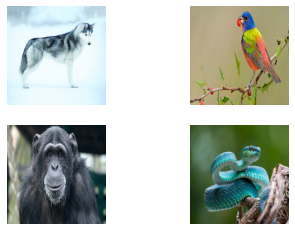

In [10]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

In [0]:
model = ResNet50(weights='imagenet')

./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566199), ('n02109961', 'Eskimo_dog', 0.41737354), ('n02110063', 'malamute', 0.020951513)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.30138975), ('n01537544', 'indigo_bunting', 0.16979532), ('n01828970', 'bee_eater', 0.16134124)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.5149853), ('n02480495', 'orangutan', 0.1589676), ('n02480855', 'gorilla', 0.15318194)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.42379686), ('n03627232', 'knot', 0.090509154), ('n01749939', 'green_mamba', 0.065577716)]


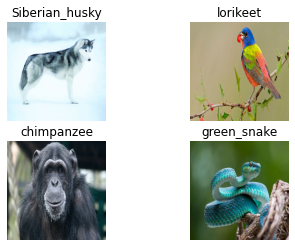

In [12]:
for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])

In [13]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [14]:

!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


**Inference with native TF2.0 saved model**

In [0]:
model = tf.keras.models.load_model('resnet50_saved_model')

./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.556619), ('n02109961', 'Eskimo_dog', 0.41737446), ('n02110063', 'malamute', 0.02095156)]


Text(0.5, 1.0, 'Siberian_husky')

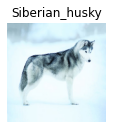

In [16]:
img_path = './data/img0.JPG'  # Siberian_husky
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
plt.subplot(2,2,1)
plt.imshow(img);
plt.axis('off');
plt.title(decode_predictions(preds, top=3)[0][0][1])

In [17]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [18]:

# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 38.4ms
Step 50: 39.1ms
Step 100: 39.6ms
Step 150: 39.3ms
Step 200: 39.0ms
Step 250: 39.4ms
Step 300: 39.2ms
Step 350: 39.7ms
Step 400: 38.9ms
Step 450: 39.3ms
Step 500: 39.1ms
Step 550: 39.6ms
Step 600: 39.7ms
Step 650: 39.3ms
Step 700: 39.3ms
Step 750: 39.7ms
Step 800: 39.6ms
Step 850: 39.7ms
Step 900: 40.0ms
Step 950: 39.9ms
Throughput: 203 images/s


**TF-TRT FP32 model**

In [19]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [20]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


In [0]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['probs'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566207), ('n02109961', 'Eskimo_dog', 0.41737258), ('n02110063', 'malamute', 0.020951604)]


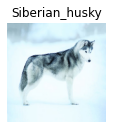

In [22]:
predict_tftrt('resnet50_saved_model_TFTRT_FP32')

In [0]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [24]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')


Step 0: 19.4ms
Step 50: 19.2ms
Step 100: 19.2ms
Step 150: 19.3ms
Step 200: 19.4ms
Step 250: 19.6ms
Step 300: 19.5ms
Step 350: 19.6ms
Step 400: 19.6ms
Step 450: 19.6ms
Step 500: 19.6ms
Step 550: 19.5ms
Step 600: 19.6ms
Step 650: 19.7ms
Step 700: 19.6ms
Step 750: 19.5ms
Step 800: 19.4ms
Step 850: 19.4ms
Step 900: 19.3ms
Step 950: 19.2ms
Throughput: 412 images/s


**TF-TRT FP16 model**

In [25]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


In [0]:
predict_tftrt('resnet50_saved_model_TFTRT_FP16')

In [0]:

benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')